In [1]:
import pyrealsense2.pyrealsense2 as rs
import numpy as np
import os
import cv2
import tensorflow as tf
from matplotlib import pyplot as plt
import scipy
from sklearn import svm

In [2]:
def retrieve_image(path):
    # Configure depth and color streams
    pipeline = rs.pipeline()
    config = rs.config()
    colorizer = rs.colorizer()

    rs.config.enable_device_from_file(config, path)
    config.enable_stream(rs.stream.depth, rs.format.z16, 30)
    config.enable_stream(rs.stream.color, rs.format.bgr8, 30)

    # Start the pipeline
    profile = pipeline.start(config)

    # Wait for a coherent pair of frames: depth and color
    frames = pipeline.wait_for_frames()
    color_frame = frames.get_color_frame()
    depth_frame = frames.get_depth_frame()

    color_image = np.asanyarray(color_frame.get_data())
    depth_image = np.asanyarray(depth_frame.get_data())
    
    return color_image, depth_image

def ceildiv(a, b):
    return -(a // -b)

def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    #image = tf.transpose(image, perm=[1, 0, 2])
    #image = tf.image.flip_left_right(image)
    image = np.uint8(image)
    return image

In [3]:
original_faces = {}
paper_faces = {}

# Go over all the images
for index, file in enumerate(os.listdir('framesets/original')):
    print("Currently Analyzing {}".format(file))

    # If the paper equivalant is not available
    if not os.path.isfile(os.path.join('framesets', 'paper', file)):
        print("Paper Equivalent of {} not found!".format(file))
        break

    original_color_image, original_depth_image = retrieve_image(os.path.join('framesets', 'original', file))
    paper_color_image, paper_depth_image = retrieve_image(os.path.join('framesets', 'paper', file))

    original_gray_image = cv2.cvtColor(original_color_image, cv2.COLOR_BGR2GRAY)
    paper_gray_image = cv2.cvtColor(paper_color_image, cv2.COLOR_BGR2GRAY)

    # Initialize the Haar-cascade classifier
    face_cascade = cv2.CascadeClassifier()
    face_cascade.load("ext/haarcascade_frontalface_default.xml")

    # Retrieve faces
    original_extracted_faces = face_cascade.detectMultiScale(original_gray_image)
    paper_extracted_faces = face_cascade.detectMultiScale(paper_gray_image)
    
    # Warnings for the original faces
    if len(original_extracted_faces) > 1:
        print("Warning! Multiple Faces Detected in the Original Image!")
    elif len(original_extracted_faces) < 1:
        print("Warning! No Faces Detected in the Original Image!")

    # Warnings for the paper faces
    if len(paper_extracted_faces) > 1:
        print("Warning! Multiple Faces Detected in the Paper Image!")
    elif len(paper_extracted_faces) < 1:
        print("Warning! No Faces Detected in the Paper Image!")

    # Loop over the original faces
    for j, (x,y,w,h) in enumerate(original_extracted_faces):
        # Exceptions
        if file == "Classroom_15_Dennis.bag" and j == 0:
            continue
        elif file == "Classroom_5_Dylan.bag" and j == 0:
            continue
        
        extracted_face_color = original_color_image[y:y+h,x:x+w]
        extracted_face_depth = original_depth_image[y:y+h,x:x+w]
        original_faces[index] = {'name': os.path.splitext(file)[0], 'color': extracted_face_color, 'depth': extracted_face_depth}

    # Loop over the paper faces
    for j, (x,y,w,h) in enumerate(paper_extracted_faces):
        extracted_face_color = paper_color_image[y:y+h,x:x+w]
        extracted_face_depth = paper_depth_image[y:y+h,x:x+w]
        paper_faces[index] = {'name': os.path.splitext(file)[0], 'color': extracted_face_color, 'depth': extracted_face_depth}

Currently Analyzing Classroom_10_Erik.bag
Currently Analyzing Classroom_11_Erwin.bag
Currently Analyzing Classroom_12_Tim.bag
Currently Analyzing Classroom_13_Tom.bag
Currently Analyzing Classroom_14_Johnny.bag
Currently Analyzing Classroom_15_Dennis.bag
Warning! Multiple Faces Detected in the Original Image!
Currently Analyzing Classroom_16_Dennis.bag
Currently Analyzing Classroom_17_Lisanne.bag
Currently Analyzing Classroom_18_Bryan.bag
Currently Analyzing Classroom_19_Eline.bag
Currently Analyzing Classroom_1_Sander.bag
Currently Analyzing Classroom_21_Arthur.bag
Currently Analyzing Classroom_2_Oscar.bag
Currently Analyzing Classroom_3_Kristo.bag
Currently Analyzing Classroom_4_Arthur.bag
Currently Analyzing Classroom_5_Dylan.bag
Warning! Multiple Faces Detected in the Original Image!
Currently Analyzing Classroom_7_Julia.bag
Currently Analyzing Classroom_8_Jesse.bag
Currently Analyzing Classroom_9_Roald.bag


# Plot Original Faces

In [126]:
color_images = []
for image in original_faces:
    color_images.append(original_faces[image]['color'])

vertical_stack = []

for i in range(0, ceildiv(len(color_images), 4)):
    horizontal_stack = []
    for j in range(0, 4):
        index = i*4+j
        if index < len(color_images):
            color_image = color_images[index]
            resized_image = distortion_free_resize(color_image, (400, 400))
            horizontal_stack.append(resized_image)
        else:
            image = np.zeros([400, 400, 3], dtype=np.uint8)
            image.fill(255)
            horizontal_stack.append(image)
            
    vertical_stack.append(np.hstack(horizontal_stack))

# Show images
cv2.namedWindow('Original Faces', cv2.WINDOW_AUTOSIZE)
cv2.imshow('Original Faces', np.vstack(vertical_stack))

while True:
    key = cv2.waitKey(1)
    # Press esc or 'q' to close the image window
    if key & 0xFF == ord('q') or key == 27:
        cv2.destroyAllWindows()
        break

# Plot Paper Faces

In [127]:
color_images = []
for image in paper_faces:
    color_images.append(paper_faces[image]['color'])

vertical_stack = []

for i in range(0, ceildiv(len(color_images), 4)):
    horizontal_stack = []
    for j in range(0, 4):
        index = i*4+j
        if index < len(color_images):
            color_image = color_images[index]
            resized_image = distortion_free_resize(color_image, (400, 400))
            horizontal_stack.append(resized_image)
        else:
            image = np.zeros([400, 400, 3], dtype=np.uint8)
            image.fill(255)
            horizontal_stack.append(image)
            
    vertical_stack.append(np.hstack(horizontal_stack))

# Show images
cv2.namedWindow('Paper Faces', cv2.WINDOW_AUTOSIZE)
cv2.imshow('Paper Faces', np.vstack(vertical_stack))

while True:
    key = cv2.waitKey(1)
    # Press esc or 'q' to close the image window
    if key & 0xFF == ord('q') or key == 27:
        cv2.destroyAllWindows()
        break

# Preprocess Depth Image

In [4]:
def preprocess_depth_image(image):
    image = image[image>0]
    image = image[image<=4000]
    return(image)

# Plot Original Face Histograms

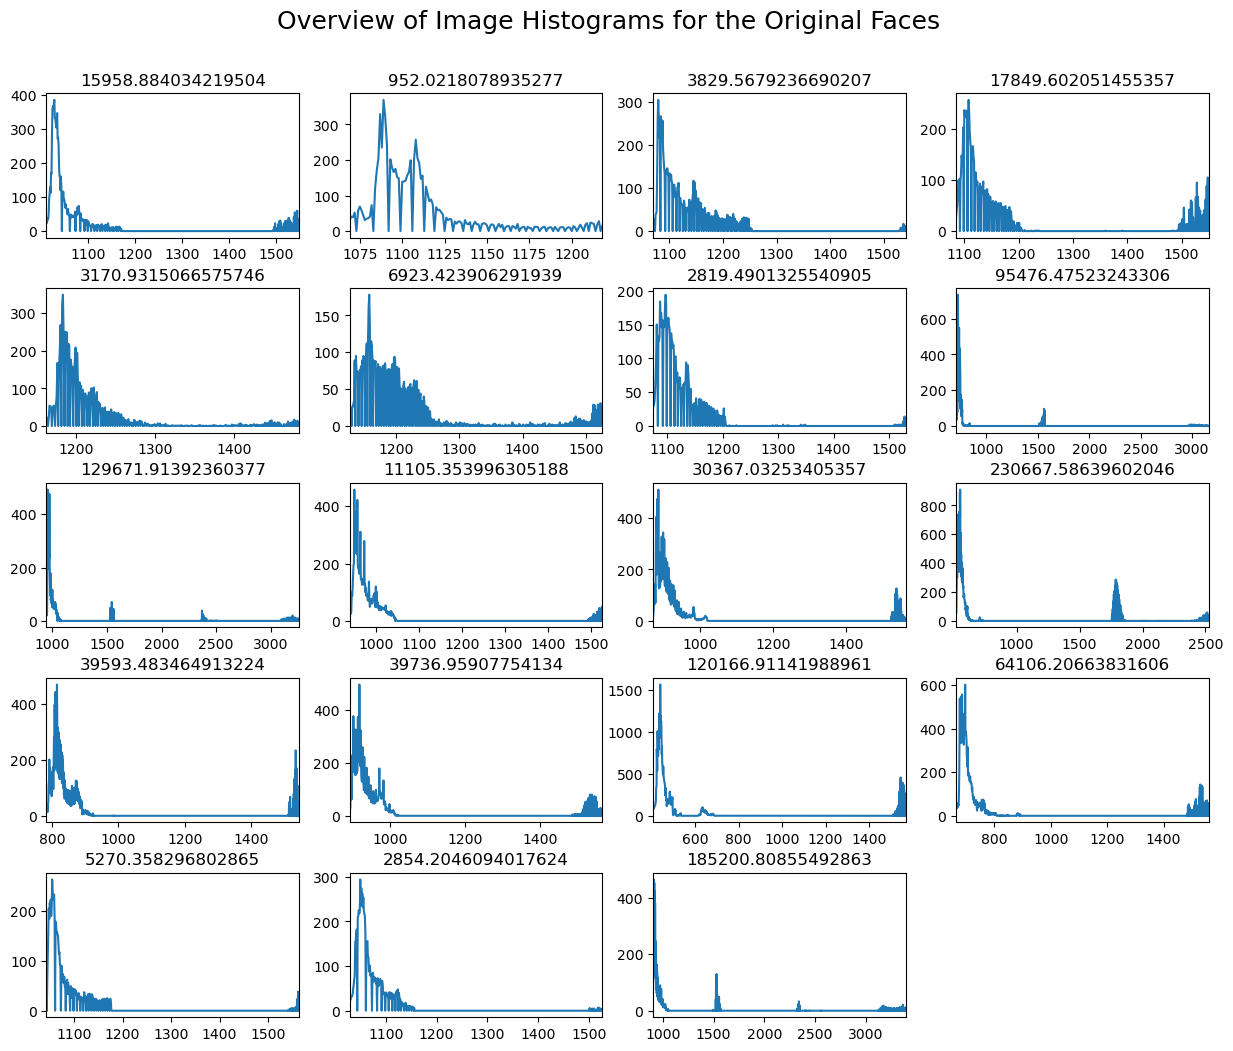

In [155]:
depth_images = []
for image in original_faces:
    depth_images.append(original_faces[image]['depth'])

plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.35)
plt.suptitle("Overview of Image Histograms for the Original Faces", fontsize=18, y=0.95)

for index, image in enumerate(depth_images):
    ax = plt.subplot(5, 4, index + 1)

    image = preprocess_depth_image(image)
    histogram = cv2.calcHist([image], [0], None, [4000], [0,4000]) # Max range of 4000
    xmin = int(np.percentile(image, 0.5))
    xmax = int(np.percentile(image, 99.5))
    plt.plot(histogram)
    plt.xlim(xmin, xmax)
    ax.set_title(index)

# Plot Paper Face Histograms

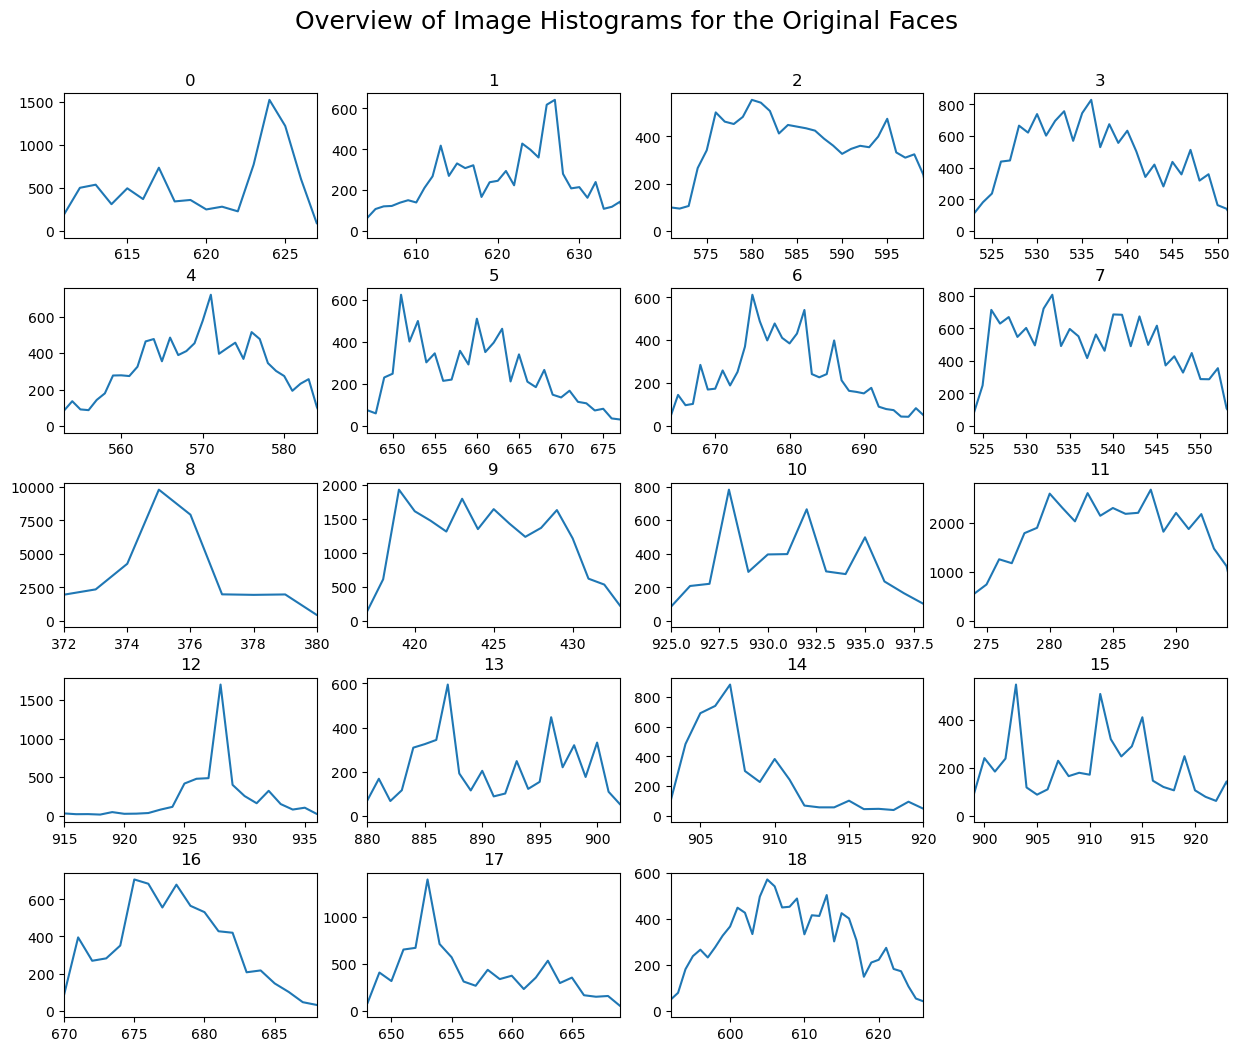

In [158]:
depth_images = []
for image in paper_faces:
    depth_images.append(paper_faces[image]['depth'])

plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.35)
plt.suptitle("Overview of Image Histograms for the Original Faces", fontsize=18, y=0.95)

for index, image in enumerate(depth_images):
    ax = plt.subplot(5, 4, index + 1)

    image = preprocess_depth_image(image)
    histogram = cv2.calcHist([image], [0], None, [4000], [0,4000]) # Max range of 4000
    xmin = int(np.percentile(image, 0.5))
    xmax = int(np.percentile(image, 99.5))
    plt.plot(histogram)
    plt.xlim(xmin, xmax)
    ax.set_title(index)

# Calculate Variance

In [5]:
depth_images = []
for image in original_faces:
    depth_images.append(original_faces[image]['depth'])

original_face_variances = []
for index, image in enumerate(depth_images):
    image = preprocess_depth_image(image)
    variance = np.var(image)
    original_face_variances.append(variance)
    print(int(variance))

print("Mean Variance: {}".format(np.mean(original_face_variances)))
print("Median Variance: {}".format(np.median(original_face_variances)))

15958
952
3829
17849
3170
6923
2819
95476
129671
11105
30367
230667
39593
39736
120166
9498
5270
2854
185200
Mean Variance: 50058.61280174721
Median Variance: 15958.884034219504


In [6]:
depth_images = []
for image in paper_faces:
    depth_images.append(paper_faces[image]['depth'])

paper_face_variances = []
for index, image in enumerate(depth_images):
    image = preprocess_depth_image(image)
    variance = np.var(image)
    paper_face_variances.append(variance)
    print(int(variance))

print("Mean Variance: {}".format(np.mean(paper_face_variances)))
print("Median Variance: {}".format(np.median(paper_face_variances)))

22
59
55
49
55
50
53
59
3
16
10
27
10
37
13
42
15
28
63
Mean Variance: 35.642889033984844
Median Variance: 37.55430549770929


# Calculate Boundary

## SVM

In [10]:
X = np.concatenate((original_face_variances, paper_face_variances), axis = 0)
Y = np.array([1]*len(original_face_variances) + [0]*len(paper_face_variances))

C = 1.0  # SVM regularization parameter
clf = svm.SVC(kernel = 'linear',  gamma=0.7, C=C)
clf.fit(X.reshape(-1, 1), Y)

boundary = (0 - clf.intercept_[0])/clf.coef_[0]

print(boundary)

[508.00327305]


## Average of Support Vectors

In [11]:
boundary = (max(paper_face_variances) + min(original_face_variances)) / 2
print("Boundary: {}".format(boundary))

Boundary: 508.0032858634291


## Prediction Test

In [18]:
print(clf.predict(np.array([508.1]).reshape(-1, 1)))

[1]


# Live Prediction

In [20]:
def make_prediction(image):
    image = preprocess_depth_image(image)
    variance = np.var(image)
    prediction = clf.predict(np.array([variance]).reshape(-1, 1))
    return prediction # 0 = paper, 1 = real

In [ ]:
# Configure depth and color streams
pipeline = rs.pipeline()
colorizer = rs.colorizer()

config = rs.config()
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)

# Get device product line for setting a supporting resolution
pipeline_wrapper = rs.pipeline_wrapper(pipeline)
pipeline_profile = config.resolve(pipeline_wrapper)
device = pipeline_profile.get_device()
device_product_line = str(device.get_info(rs.camera_info.product_line))

# Start the pipeline
profile = pipeline.start(config)

# Initialize the Haar-cascade classifier
face_cascade = cv2.CascadeClassifier();
face_cascade.load("ext/haarcascade_frontalface_default.xml");

try:
    while True:
        # Wait for a coherent pair of frames: depth and color
        frames = pipeline.wait_for_frames()
        align = rs.align(rs.stream.color)
        aligned_frames = align.process(frames)
        depth_frame = aligned_frames.get_depth_frame().as_frame()
        depth_color_frame = rs.colorizer().colorize(depth_frame)
        color_frame = aligned_frames.get_color_frame().as_frame()
        if not depth_frame or not color_frame:
            continue

        # Convert images to numpy arrays
        depth_image = np.asanyarray(depth_frame.get_data())
        depth_colormap = np.asanyarray(depth_color_frame.get_data())
        color_image = np.asanyarray(color_frame.get_data())
        gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)

        # Apply colormap on depth image (image must be converted to 8-bit per pixel first)
        depth_colormap_dim = depth_colormap.shape
        color_colormap_dim = color_image.shape

        # Apply Haar-cascade classifier
        faces = face_cascade.detectMultiScale(gray_image)

        # Extract a copy of the original images to draw onto
        color_image_display = color_image.copy()
        depth_colormap_display = depth_colormap.copy()

        for (x,y,w,h) in faces:
            extracted_face_color = color_image_display[y:y+h,x:x+w]
            extracted_face_depth = color_image_display[y:y+h,x:x+w]

            prediction = make_prediction(extracted_face_depth)

            if prediction == 0: # Paper Face
                # Add rectangles
                cv2.rectangle(color_image_display, (x, y), (x+w, y+h), (0, 0, 255), 1)
                cv2.rectangle(depth_colormap_display, (x, y), (x+w, y+h), (0, 0, 255), 1)

                # Add text
                cv2.putText(color_image_display, 'Non-Authentic Face', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
                cv2.putText(depth_colormap_display, 'Non-Authentic Face', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
            elif prediction == 1: # Real Face
                # Add rectangles
                cv2.rectangle(color_image_display, (x, y), (x+w, y+h), (0, 255, 0), 1)
                cv2.rectangle(depth_colormap_display, (x, y), (x+w, y+h), (0, 255, 0), 1)

                # Add text
                cv2.putText(color_image_display, 'Authentic Face', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
                cv2.putText(depth_colormap_display, 'Authentic Face', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        # If depth and color resolutions are different, resize color image to match depth image for display
        if depth_colormap_dim != color_colormap_dim:
            resized_color_image = cv2.resize(color_image_display, dsize=(depth_colormap_dim[1], depth_colormap_dim[0]), interpolation=cv2.INTER_AREA)
            images = np.hstack((resized_color_image, depth_colormap_display))
        else:
            images = np.hstack((color_image_display, depth_colormap_display))

        # Show images
        cv2.namedWindow('Live Prediction', cv2.WINDOW_AUTOSIZE)
        cv2.imshow('Live Prediction', images)

        key = cv2.waitKey(1)
        # Press esc or 'q' to close the image window
        if key & 0xFF == ord('q') or key == 27:
            cv2.destroyAllWindows()
            break
finally:
    # Stop streaming
    pipeline.stop()